In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import glob
from matplotlib.colors import Normalize
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt, decimate
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks


# Assigned ranges for analysis
range1=("092022", "092212")
range2=("091122", "091312")
range3=("090302", "090452")


In [2]:
def get_range(ts_start: str, ts_end: str, dx=5.1065, dt=0.0016):
    files = glob.glob("../data/*.npy")
    files.sort()
    
    def extract_ts(path):
        fname = path.split("\\")[-1].split("/")[-1].split(".")[0]
        return datetime.datetime.strptime("2024-05-07 " + fname, "%Y-%m-%d %H%M%S")
    
    ts_start_dt = datetime.datetime.strptime("2024-05-07 " + ts_start, "%Y-%m-%d %H%M%S")
    ts_end_dt = datetime.datetime.strptime("2024-05-07 " + ts_end, "%Y-%m-%d %H%M%S")
    
    selected = []
    timestamps = []
    for f in files:
        ts = extract_ts(f)
        if ts_start_dt <= ts <= ts_end_dt:
            selected.append(f)
            timestamps.append(ts)
    
    if not selected:
        raise ValueError("No files found between the given timestamps.")
    
    arrays = [np.load(f) for f in selected]
    data = np.concatenate(arrays)
    
    index = pd.date_range(start=timestamps[0], periods=len(data), freq=f"{dt}s")
    columns = np.arange(data.shape[1]) * dx
    df = pd.DataFrame(data=data, index=index, columns=columns)
    
    return {"data": data, "df": df, "dt": dt, "dx": dx}

In [ ]:
def set_axis(axis_data):
    """Helper function to set axis ticks"""
    n = len(axis_data)
    positions = np.linspace(0, n-1, min(10, n))
    labels = [axis_data[int(p)] for p in positions]
    return positions, labels

def plot_data(result, figsize=(12, 16), cmap='viridis', apply_transform=True, percentiles=[3, 99]):
    """
    Plot DAS data as a heatmap (time vs distance).
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    figsize : tuple
        Figure size (width, height)
    cmap : str
        Colormap for the plot
    apply_transform : bool
        If True, applies mean subtraction and absolute value transform
    percentiles : list
        Percentile values [low, high] for color normalization
    
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    """
    df = result['df'].copy()
    
    # Apply transformation
    if apply_transform:
        df -= df.mean()
        df = np.abs(df)
    
    # Normalize using percentiles
    low, high = np.percentile(df, percentiles)
    norm = Normalize(vmin=low, vmax=high, clip=True)
    
    fig = plt.figure(figsize=figsize)
    ax = plt.axes()
    
    # Plot the data
    im = ax.imshow(df, interpolation='none', aspect='auto', norm=norm, cmap=cmap)
    
    plt.ylabel('time')
    plt.xlabel('space [m]')
    
    # Add colorbar with custom positioning
    cax = fig.add_axes([ax.get_position().x1+0.06, ax.get_position().y0, 0.02, ax.get_position().height])
    plt.colorbar(im, cax=cax)
    
    # Set axis ticks
    x_positions, x_labels = set_axis(df.columns)
    ax.set_xticks(x_positions, np.round(x_labels))
    
    y_positions, y_labels = set_axis(df.index.time)
    ax.set_yticks(y_positions, y_labels)
    
    plt.show()
    
    return fig, ax

In [88]:
def plot_comparison(result1, result2, title1="Original", title2="Processed", 
                    figsize=(24, 16), cmap='viridis', apply_transform=True, percentiles=[3, 99]):
    """
    Plot two DAS datasets side by side for comparison.
    
    Parameters:
    -----------
    result1, result2 : dict
        Dictionaries returned by get_range() or filter functions
    title1, title2 : str
        Titles for the left and right plots
    figsize : tuple
        Figure size (width, height)
    cmap : str
        Colormap for the plots
    apply_transform : bool
        If True, applies mean subtraction and absolute value transform
    percentiles : list
        Percentile values [low, high] for color normalization
    
    Returns:
    --------
    fig, (ax1, ax2) : matplotlib figure and axes objects
    """
    df1 = result1['df'].copy()
    df2 = result2['df'].copy()
    
    # Apply transformation
    if apply_transform:
        df1 -= df1.mean()
        df1 = np.abs(df1)
        df2 -= df2.mean()
        df2 = np.abs(df2)
    
    # Normalize using percentiles
    low, high = np.percentile(df1, percentiles)
    low2, high2 = np.percentile(df2, percentiles)
    norm = Normalize(vmin=low, vmax=high, clip=True)
    norm2 = Normalize(vmin=low2, vmax=high2, clip=True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot left (original)
    im1 = ax1.imshow(df1, interpolation='none', aspect='auto', norm=norm, cmap=cmap)
    ax1.set_ylabel('time')
    ax1.set_xlabel('space [m]')
    ax1.set_title(title1)
    
    x_positions1, x_labels1 = set_axis(df1.columns)
    ax1.set_xticks(x_positions1, np.round(x_labels1))
    y_positions1, y_labels1 = set_axis(df1.index.time)
    ax1.set_yticks(y_positions1, y_labels1)
    
    # Plot right (processed)
    im2 = ax2.imshow(df2, interpolation='none', aspect='auto', norm=norm2, cmap=cmap)
    ax2.set_ylabel('time')
    ax2.set_xlabel('space [m]')
    ax2.set_title(title2)
    
    x_positions2, x_labels2 = set_axis(df2.columns)
    ax2.set_xticks(x_positions2, np.round(x_labels2))
    y_positions2, y_labels2 = set_axis(df2.index.time)
    ax2.set_yticks(y_positions2, y_labels2)
    
    # Add colorbars
    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar1.set_label('Amplitude')
    cbar2 = plt.colorbar(im2, ax=ax2)
    cbar2.set_label('Amplitude')
    
    plt.tight_layout()
    plt.show()
    
    return fig, (ax1, ax2)

In [32]:
def bandpass_filter(result, lowcut=5, highcut=50, order=4):
    """
    Apply bandpass filter to DAS data to isolate vehicle frequencies.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    lowcut : float
        Low cutoff frequency in Hz (default: 5 Hz)
    highcut : float
        High cutoff frequency in Hz (default: 50 Hz)
    order : int
        Filter order (default: 4)
    
    Returns:
    --------
    dict : Same structure as input with filtered data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    dt = result['dt']
    dx = result['dx']
    data = result['data']
    df = result['df']
    
    # Calculate sampling frequency
    fs = 1.0 / dt
    
    # Normalize cutoff frequencies
    nyquist = fs / 2.0
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Design Butterworth bandpass filter
    b, a = butter(order, [low, high], btype='band')
    
    # Apply filter to each spatial channel (column)
    filtered_data = np.zeros_like(data)
    for i in range(data.shape[1]):
        filtered_data[:, i] = filtfilt(b, a, data[:, i])
    
    # Create filtered DataFrame with same index and columns
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

In [199]:
def magnitude_threshold_filter(result, lower_percentile=5, upper_percentile=95, 
                               method='clip', replace_value=0):
    """
    Filter data based on magnitude percentiles to remove outliers and extreme values.
    
    This removes or clips values outside the specified percentile range, helping to
    eliminate noise spikes, sensor artifacts, and extreme outliers.
    
    Parameters:
    -----------
    result : dict
        Dictionary from get_range() or other functions
    lower_percentile : float
        Lower percentile threshold (0-100), values below this are filtered (default=5)
    upper_percentile : float
        Upper percentile threshold (0-100), values above this are filtered (default=95)
    method : str
        'clip' - Clip values to percentile bounds (default)
        'zero' - Set out-of-range values to zero
        'nan' - Set out-of-range values to NaN (useful for visualization)
        'remove' - Remove out-of-range values (sets to replace_value)
    replace_value : float
        Value to use when method='remove' (default=0)
    
    Returns:
    --------
    dict : Filtered result
    
    Examples:
    ---------
    # Remove extreme 5% on each end
    filtered = magnitude_threshold_filter(data, lower_percentile=5, upper_percentile=95)
    
    # More aggressive filtering
    filtered = magnitude_threshold_filter(data, lower_percentile=10, upper_percentile=90)
    
    # Keep only strongest signals
    filtered = magnitude_threshold_filter(data, lower_percentile=75, upper_percentile=100, method='zero')
    """
    data = result['data'].copy().astype(np.float64)
    
    # Calculate percentile thresholds
    lower_threshold = np.percentile(data, lower_percentile)
    upper_threshold = np.percentile(data, upper_percentile)
    
    print(f"Magnitude thresholding:")
    print(f"  Lower threshold ({lower_percentile}%): {lower_threshold:.6f}")
    print(f"  Upper threshold ({upper_percentile}%): {upper_threshold:.6f}")
    
    # Apply filtering based on method
    if method == 'clip':
        # Clip values to the percentile bounds
        filtered_data = np.clip(data, lower_threshold, upper_threshold)
        n_affected = np.sum((data < lower_threshold) | (data > upper_threshold))
        
    elif method == 'zero':
        # Set out-of-range values to zero
        mask = (data >= lower_threshold) & (data <= upper_threshold)
        filtered_data = np.where(mask, data, 0)
        n_affected = np.sum(~mask)
        
    elif method == 'nan':
        # Set out-of-range values to NaN
        mask = (data >= lower_threshold) & (data <= upper_threshold)
        filtered_data = np.where(mask, data, np.nan)
        n_affected = np.sum(~mask)
        
    elif method == 'remove':
        # Set out-of-range values to custom replace_value
        mask = (data >= lower_threshold) & (data <= upper_threshold)
        filtered_data = np.where(mask, data, replace_value)
        n_affected = np.sum(~mask)
        
    else:
        raise ValueError(f"Unknown method: {method}. Use 'clip', 'zero', 'nan', or 'remove'")
    
    n_total = data.size
    percent_affected = 100 * n_affected / n_total
    print(f"  Affected values: {n_affected:,} / {n_total:,} ({percent_affected:.2f}%)")
    
    # Create DataFrame
    df_filtered = pd.DataFrame(
        data=filtered_data,
        index=result['df'].index,
        columns=result['df'].columns
    )
    
    return {
        'data': filtered_data,
        'df': df_filtered,
        'dt': result['dt'],
        'dx': result['dx'],
        'thresholds': {'lower': lower_threshold, 'upper': upper_threshold}
    }


def adaptive_magnitude_filter(result, window_size=1000, percentile_range=(5, 95), 
                               method='clip'):
    """
    Apply adaptive magnitude filtering using a sliding window.
    
    Instead of using global percentiles, this computes percentiles locally in a sliding
    window, allowing the filter to adapt to varying signal conditions across time.
    
    Parameters:
    -----------
    result : dict
        Dictionary from get_range() or other functions
    window_size : int
        Size of the sliding window in samples (default=1000)
    percentile_range : tuple
        (lower_percentile, upper_percentile) for filtering (default=(5, 95))
    method : str
        'clip', 'zero', or 'remove' (same as magnitude_threshold_filter)
    
    Returns:
    --------
    dict : Filtered result
    """
    from scipy.ndimage import uniform_filter
    
    data = result['data'].copy().astype(np.float64)
    filtered_data = np.zeros_like(data)
    
    lower_p, upper_p = percentile_range
    half_window = window_size // 2
    
    print(f"Adaptive magnitude filtering (window={window_size})...")
    
    # Process each time step with local percentiles
    for i in range(data.shape[0]):
        # Define window bounds
        start = max(0, i - half_window)
        end = min(data.shape[0], i + half_window)
        
        # Compute local percentiles
        window_data = data[start:end, :]
        lower_thresh = np.percentile(window_data, lower_p)
        upper_thresh = np.percentile(window_data, upper_p)
        
        # Apply filtering for this row
        if method == 'clip':
            filtered_data[i, :] = np.clip(data[i, :], lower_thresh, upper_thresh)
        elif method == 'zero':
            mask = (data[i, :] >= lower_thresh) & (data[i, :] <= upper_thresh)
            filtered_data[i, :] = np.where(mask, data[i, :], 0)
        elif method == 'remove':
            mask = (data[i, :] >= lower_thresh) & (data[i, :] <= upper_thresh)
            filtered_data[i, :] = np.where(mask, data[i, :], 0)
    
    print(f"  ✓ Adaptive filtering complete")
    
    # Create DataFrame
    df_filtered = pd.DataFrame(
        data=filtered_data,
        index=result['df'].index,
        columns=result['df'].columns
    )
    
    return {
        'data': filtered_data,
        'df': df_filtered,
        'dt': result['dt'],
        'dx': result['dx']
    }

In [ ]:
# Test magnitude threshold filtering
raw_data = get_range(range1[0], range1[1])

# Method 1: Standard percentile filtering (removes outliers)
print("="*60)
print("METHOD 1: Remove outlier extremes (5-95 percentile)")
print("="*60)
filtered_outliers = magnitude_threshold_filter(
    raw_data, 
    lower_percentile=5, 
    upper_percentile=95, 
    method='clip'
)

# Method 2: Keep only strong signals (aggressive filtering)
print("\n" + "="*60)
print("METHOD 2: Keep only strongest signals (75-100 percentile)")
print("="*60)
filtered_strong = magnitude_threshold_filter(
    raw_data, 
    lower_percentile=75, 
    upper_percentile=100, 
    method='zero'
)

# Compare results
plot_comparison(
    raw_data, 
    filtered_outliers, 
    title1="Original Data", 
    title2="Outliers Removed (5-95%)",
    apply_transform=True
)

plot_comparison(
    raw_data, 
    filtered_strong, 
    title1="Original Data", 
    title2="Strong Signals Only (75-100%)",
    apply_transform=True
)

In [63]:
def remove_spatial_noise(result, method='median', window_size=5):
    """
    Remove column-wise (spatial) background noise from DAS data.
    
    This addresses vertical striping/banding where each spatial channel
    has a different DC offset or slowly varying background level.
    
    Parameters:
    -----------
    result : dict
        Dictionary from get_range() or other functions
    method : str
        'median' - subtract spatial median (robust to outliers)
        'mean' - subtract spatial mean (faster but sensitive to outliers)
        'highpass' - spatial high-pass filter (removes slow spatial variations)
    window_size : int
        Window size for spatial filtering (only for 'highpass' method)
    
    Returns:
    --------
    dict : Same structure with spatial noise removed
    """
    from scipy.ndimage import median_filter, uniform_filter
    
    data = result['data'].copy()
    
    if method == 'median':
        # For each time sample, subtract the spatial median
        # This removes column-wise offsets
        spatial_median = np.median(data, axis=1, keepdims=True)
        data_clean = data - spatial_median
        
    elif method == 'mean':
        # Subtract spatial mean (faster but less robust)
        spatial_mean = np.mean(data, axis=1, keepdims=True)
        data_clean = data - spatial_mean
        
    elif method == 'highpass':
        # Spatial high-pass: subtract smoothed version
        # This removes slowly varying spatial patterns
        data_smooth = median_filter(data, size=(1, window_size))
        data_clean = data - data_smooth
        
    else:
        raise ValueError(f"Unknown method: {method}. Use 'median', 'mean', or 'highpass'")
    
    # Create DataFrame
    df_clean = pd.DataFrame(
        data=data_clean,
        index=result['df'].index,
        columns=result['df'].columns
    )
    
    return {
        'data': data_clean,
        'df': df_clean,
        'dt': result['dt'],
        'dx': result['dx']
    }

In [111]:
def enhance_moving_variance(result, window=25):
    """
    Enhance transient events using moving variance.
    
    Parameters:
    -----------
    result : dict
        Dictionary from get_range() or other functions
    window : int
        Window size for moving variance (default=25)
    
    Returns:
    --------
    dict : Enhanced result
    """
    from scipy.ndimage import uniform_filter
    
    data = result['data'].copy().astype(np.float64)
    
    # Compute moving variance
    mean = uniform_filter(data, size=(window, 1), mode='nearest')
    mean_sq = uniform_filter(data**2, size=(window, 1), mode='nearest')
    variance = np.maximum(mean_sq - mean**2, 0)
    enhanced = np.sqrt(variance)
    
    # Normalize
    low, high = np.percentile(enhanced, [5, 95])
    enhanced = np.clip((enhanced - low) / (high - low + 1e-10), 0, 1)
    enhanced = np.power(enhanced, 0.7)
    
    df_enhanced = pd.DataFrame(
        data=enhanced,
        index=result['df'].index[:enhanced.shape[0]],
        columns=result['df'].columns[:enhanced.shape[1]]
    )
    
    return {
        'data': enhanced,
        'df': df_enhanced,
        'dt': result['dt'],
        'dx': result['dx']
    }


def enhance_gradient(result, sigma=1.5):
    """
    Enhance diagonal structures using directional gradient.
    
    Parameters:
    -----------
    result : dict
        Dictionary from get_range() or other functions
    sigma : float
        Gaussian sigma before gradient (default=1.5)
    
    Returns:
    --------
    dict : Enhanced result
    """
    from scipy.ndimage import gaussian_filter, sobel
    
    data = result['data'].copy().astype(np.float64)
    
    # Smooth first to reduce noise
    data_smooth = gaussian_filter(data, sigma=(sigma, sigma*0.5))
    
    # Compute gradients
    grad_x = sobel(data_smooth, axis=1)  # Spatial gradient
    grad_y = sobel(data_smooth, axis=0)  # Temporal gradient
    
    # Diagonal gradient magnitude (vehicles create diagonal patterns)
    enhanced = np.sqrt(grad_x**2 + grad_y**2)
    
    # Normalize
    low, high = np.percentile(enhanced, [5, 95])
    enhanced = np.clip((enhanced - low) / (high - low + 1e-10), 0, 1)
    enhanced = np.power(enhanced, 0.7)
    
    df_enhanced = pd.DataFrame(
        data=enhanced,
        index=result['df'].index[:enhanced.shape[0]],
        columns=result['df'].columns[:enhanced.shape[1]]
    )
    
    return {
        'data': enhanced,
        'df': df_enhanced,
        'dt': result['dt'],
        'dx': result['dx']
    }


def enhance_spatial_smooth(result, sigma=0.5):
    """
    Apply spatial smoothing to reduce channel noise.
    
    Parameters:
    -----------
    result : dict
        Dictionary from get_range() or other functions
    sigma : float
        Spatial smoothing sigma (default=0.5)
    
    Returns:
    --------
    dict : Enhanced result
    """
    from scipy.ndimage import gaussian_filter
    
    data = result['data'].copy().astype(np.float64)
    
    # Apply spatial smoothing
    enhanced = gaussian_filter(data, sigma=(0, sigma))
    
    # Normalize
    low, high = np.percentile(enhanced, [5, 95])
    enhanced = np.clip((enhanced - low) / (high - low + 1e-10), 0, 1)
    enhanced = np.power(enhanced, 0.7)
    
    df_enhanced = pd.DataFrame(
        data=enhanced,
        index=result['df'].index[:enhanced.shape[0]],
        columns=result['df'].columns[:enhanced.shape[1]]
    )
    
    return {
        'data': enhanced,
        'df': df_enhanced,
        'dt': result['dt'],
        'dx': result['dx']
    }


def enhance_morphological(result, size=(3, 3), suppress_background=True, threshold_percentile=60):
    """
    Apply morphological closing to connect broken lines.
    
    Parameters:
    -----------
    result : dict
        Dictionary from get_range() or other functions
    size : tuple
        Structuring element size (default=(3, 3))
    suppress_background : bool
        If True, applies background suppression after morphological operations (default=True)
    threshold_percentile : float
        Percentile threshold for background suppression (default=60)
    
    Returns:
    --------
    dict : Enhanced result
    """
    from scipy.ndimage import grey_closing
    
    data = result['data'].copy().astype(np.float64)
    
    # Apply morphological closing
    enhanced = grey_closing(data, size=size)
    
    # Optional: Suppress background noise
    if suppress_background:
        # Threshold to remove low-intensity background
        threshold = np.percentile(enhanced, threshold_percentile)
        enhanced = np.where(enhanced > threshold, enhanced - threshold, 0)
    
    # Normalize with emphasis on preserving strong signals
    if enhanced.max() > 0:
        low, high = np.percentile(enhanced[enhanced > 0], [2, 98])
        enhanced = np.clip((enhanced - low) / (high - low + 1e-10), 0, 1)
        # Apply stronger gamma to suppress remaining noise
        enhanced = np.power(enhanced, 1.2)
    
    df_enhanced = pd.DataFrame(
        data=enhanced,
        index=result['df'].index[:enhanced.shape[0]],
        columns=result['df'].columns[:enhanced.shape[1]]
    )
    
    return {
        'data': enhanced,
        'df': df_enhanced,
        'dt': result['dt'],
        'dx': result['dx']
    }


def enhance_vehicle_lines_combined(result, variance_window=25, gradient_sigma=1.5, 
                                    spatial_smooth=0.5, morphological_size=(3, 3)):
    """
    Enhance diagonal vehicle traces using a combined multi-stage pipeline.
    
    This function combines multiple enhancement techniques in sequence:
    1. Moving variance (enhances transients)
    2. Spatial smoothing (reduces channel noise)
    3. Gradient enhancement (emphasizes diagonal structures)
    4. Morphological closing (connects broken lines)
    
    Parameters:
    -----------
    result : dict
        Dictionary from get_range() or other functions
    variance_window : int
        Window for moving variance (default=25)
    gradient_sigma : float
        Gaussian sigma before gradient (default=1.5)
    spatial_smooth : float
        Spatial smoothing sigma (default=0.5)
    morphological_size : tuple
        Structuring element size for morphological operations (default=(3, 3))
    
    Returns:
    --------
    dict : Enhanced result
    """
    from scipy.ndimage import gaussian_filter, sobel, uniform_filter, grey_closing
    
    data = result['data'].copy().astype(np.float64)
    
    print("Enhancing vehicle lines (combined method):")
    
    # Stage 1: Moving variance (enhances transients)
    print("  [1/4] Computing moving variance...")
    mean = uniform_filter(data, size=(variance_window, 1), mode='nearest')
    mean_sq = uniform_filter(data**2, size=(variance_window, 1), mode='nearest')
    variance = np.maximum(mean_sq - mean**2, 0)
    data_var = np.sqrt(variance)
    
    # Stage 2: Spatial smoothing (reduce channel noise)
    print("  [2/4] Spatial smoothing...")
    data_smooth = gaussian_filter(data_var, sigma=(0, spatial_smooth))
    
    # Stage 3: Gradient enhancement (emphasize diagonal structures)
    print("  [3/4] Gradient enhancement...")
    data_smooth2 = gaussian_filter(data_smooth, sigma=(gradient_sigma, gradient_sigma*0.5))
    grad_x = sobel(data_smooth2, axis=1)
    grad_y = sobel(data_smooth2, axis=0)
    grad_mag = np.sqrt(grad_x**2 + grad_y**2)
    
    # Stage 4: Morphological closing (connect broken lines)
    print("  [4/4] Morphological operations...")
    enhanced = grey_closing(grad_mag, size=morphological_size)
    
    print(f"  ✓ Enhancement complete")
    
    # Normalize using percentiles with wider range to preserve more detail
    low, high = np.percentile(enhanced, [5, 95])
    enhanced = np.clip((enhanced - low) / (high - low + 1e-10), 0, 1)
    
    # Apply power transform to compress highlights and expand shadows
    enhanced = np.power(enhanced, 0.7)  # Gamma correction to reduce brightness
    
    # Create DataFrame
    df_enhanced = pd.DataFrame(
        data=enhanced,
        index=result['df'].index[:enhanced.shape[0]],
        columns=result['df'].columns[:enhanced.shape[1]]
    )
    
    return {
        'data': enhanced,
        'df': df_enhanced,
        'dt': result['dt'],
        'dx': result['dx']
    }




In [112]:
def suppress_background(result, method='threshold', **kwargs):
    """
    Suppress background noise while preserving vehicle lines.
    
    Parameters:
    -----------
    result : dict
        Dictionary from get_range() or other functions
    method : str
        'threshold' - Apply adaptive thresholding (default)
        'tophat' - Use morphological top-hat transform
        'percentile' - Zero out values below percentile threshold
        'contrast' - Enhance contrast using CLAHE-like approach
    
    Additional parameters:
        threshold_percentile : float (default=75) - Percentile for threshold method
        tophat_size : int (default=15) - Structuring element size for top-hat
        percentile_cutoff : float (default=50) - Percentile below which to zero out
        contrast_clip : float (default=0.03) - Clipping limit for contrast enhancement
    
    Returns:
    --------
    dict : Result with suppressed background
    """
    data = result['data'].copy().astype(np.float64)
    
    if method == 'threshold':
        # Apply adaptive thresholding based on percentile
        threshold_percentile = kwargs.get('threshold_percentile', 75)
        threshold = np.percentile(data, threshold_percentile)
        
        # Set everything below threshold to zero, scale above threshold
        suppressed = np.where(data > threshold, data - threshold, 0)
        
    elif method == 'tophat':
        # Morphological top-hat to remove background
        from scipy.ndimage import white_tophat, grey_opening
        tophat_size = kwargs.get('tophat_size', 15)
        
        # White top-hat: original - opening (removes dark background)
        suppressed = white_tophat(data, size=(tophat_size, tophat_size))
        
    elif method == 'percentile':
        # Zero out values below a percentile threshold
        percentile_cutoff = kwargs.get('percentile_cutoff', 50)
        threshold = np.percentile(data, percentile_cutoff)
        
        suppressed = np.where(data > threshold, data, 0)
        
    elif method == 'contrast':
        # Contrast enhancement with background suppression
        contrast_clip = kwargs.get('contrast_clip', 0.03)
        
        # Normalize to 0-1
        data_min, data_max = np.percentile(data, [1, 99])
        normalized = np.clip((data - data_min) / (data_max - data_min + 1e-10), 0, 1)
        
        # Apply power law to suppress low values
        suppressed = np.power(normalized, 1.5)  # Gamma > 1 darkens low values
        
        # Clip very low values to zero
        suppressed = np.where(suppressed < contrast_clip, 0, suppressed - contrast_clip)
        
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Normalize the result
    if suppressed.max() > 0:
        low, high = np.percentile(suppressed[suppressed > 0], [5, 95])
        suppressed = np.clip((suppressed - low) / (high - low + 1e-10), 0, 1)
    
    df_suppressed = pd.DataFrame(
        data=suppressed,
        index=result['df'].index[:suppressed.shape[0]],
        columns=result['df'].columns[:suppressed.shape[1]]
    )
    
    return {
        'data': suppressed,
        'df': df_suppressed,
        'dt': result['dt'],
        'dx': result['dx']
    }


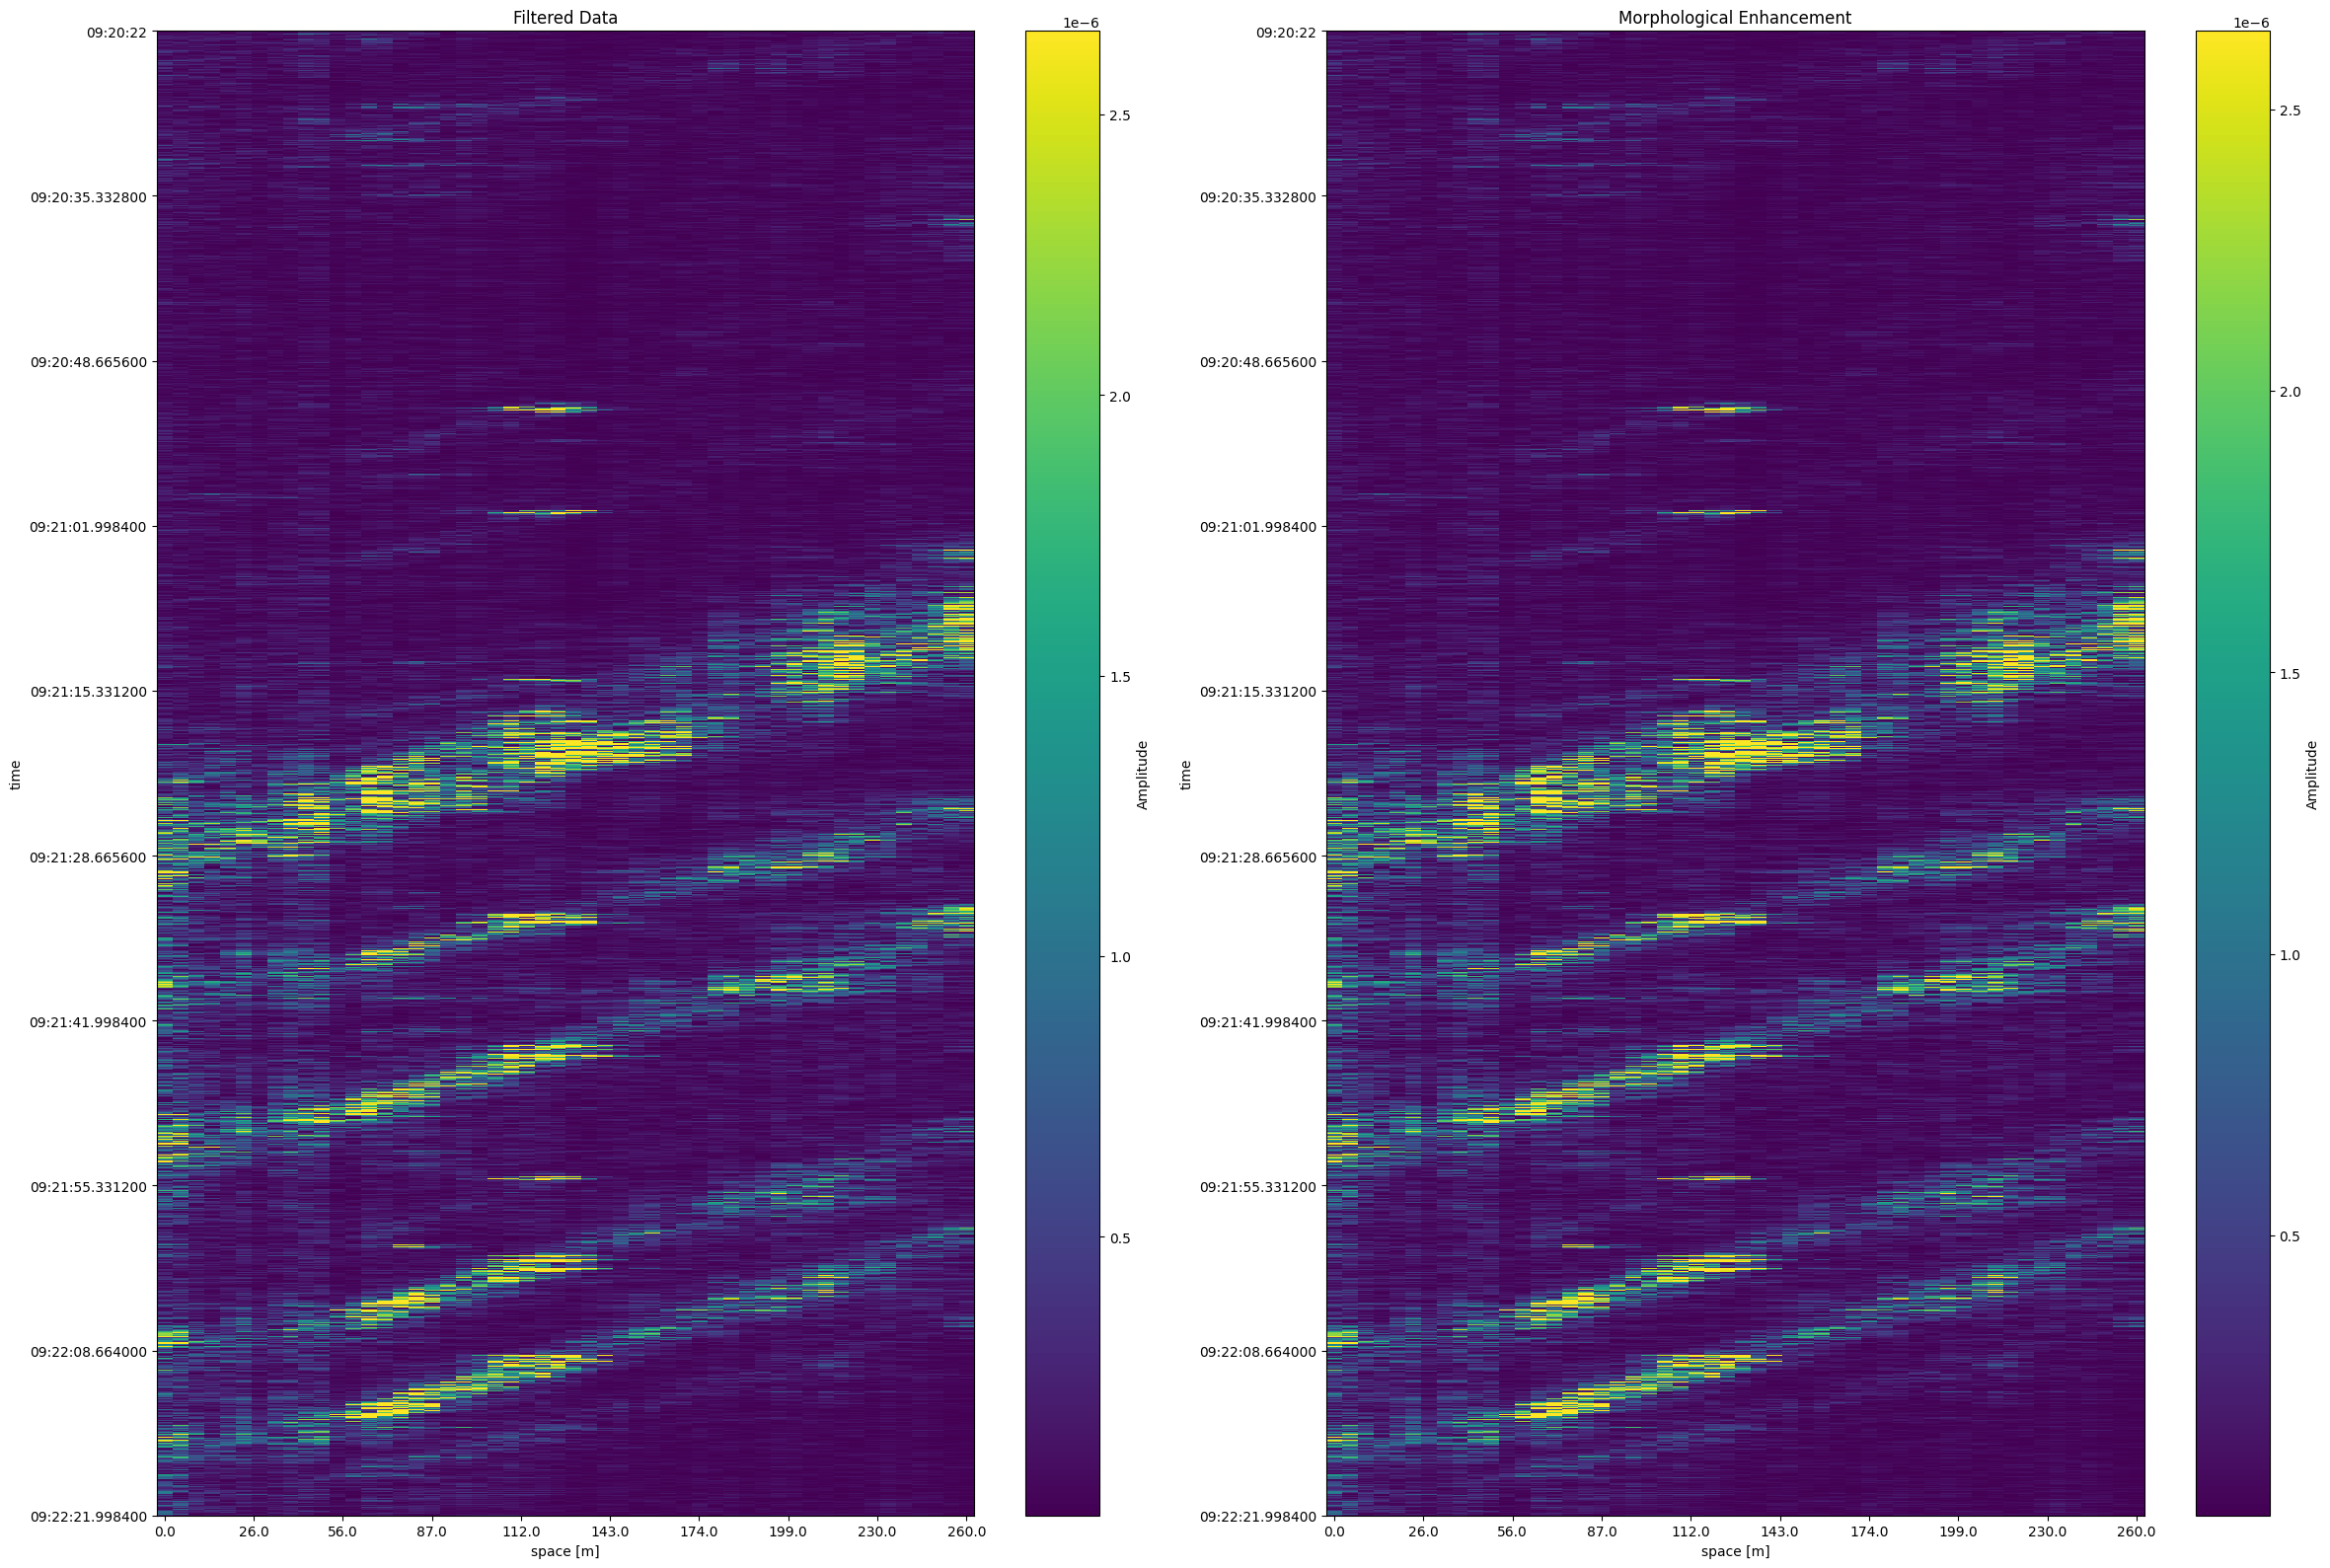

(<Figure size 2400x1600 with 4 Axes>,
 (<Axes: title={'center': 'Filtered Data'}, xlabel='space [m]', ylabel='time'>,
  <Axes: title={'center': 'Morphological Enhancement'}, xlabel='space [m]', ylabel='time'>))

In [134]:
raw_data = get_range(range1[0], range1[1])
preprocessing_result = remove_spatial_noise(raw_data, method='median', window_size=5)
filtered_data = bandpass_filter(preprocessing_result, lowcut=5, highcut=50, order=4)

enh_grad = enhance_gradient(filtered_data, sigma=1)
enh_morph = enhance_morphological(enh_grad, size=(7, 7), suppress_background=True, threshold_percentile=50)

plot_comparison(raw_data, preprocessing_result, title1="Filtered Data", title2="Morphological Enhancement")


In [135]:
def detect_objects(result, apply_transform=True, percentiles=[3, 99], 
                   denoise_pre_canny=True, denoise_sigma=2.0,
                   threshold_before_canny=True, threshold_percentile=80,
                   canny_sigma=1.0, canny_low=0.2, canny_high=0.5,
                   hough_threshold=50, hough_line_length=50, hough_line_gap=10,
                   angle_tolerance=30):
    """
    Detect objects (vehicles) in DAS data using edge detection and Hough Transform.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() or filter functions
    apply_transform : bool
        If True, applies mean subtraction and absolute value transform
    percentiles : list
        Percentile values [low, high] for normalization
    denoise_pre_canny : bool
        If True, applies Gaussian denoising before edge detection (default=True)
    denoise_sigma : float
        Sigma for Gaussian denoising (default=2.0)
    threshold_before_canny : bool
        If True, applies thresholding to reduce noise before Canny (default=True)
    threshold_percentile : float
        Percentile threshold to suppress weak signals (default=80)
    canny_sigma : float
        Standard deviation of Gaussian filter for Canny edge detection (default=1.0)
    canny_low, canny_high : float
        Lower and upper thresholds for Canny edge detection (default=0.2, 0.5)
    hough_threshold : int
        Minimum number of votes for Hough line detection (default=50)
    hough_line_length : int
        Minimum length of detected lines (default=50)
    hough_line_gap : int
        Maximum gap between line segments (default=10)
    angle_tolerance : float
        Maximum angle (in degrees) from horizontal/vertical to consider as vehicle trace
    
    Returns:
    --------
    dict : Detection results containing:
        'edges': binary edge image
        'lines': detected lines from Hough transform
        'velocities': list of estimated velocities (m/s)
        'processed_data': normalized and processed data
        'result': original result dict
    """
    from scipy.ndimage import gaussian_filter, median_filter
    
    df = result['df'].copy()
    dt = result['dt']
    dx = result['dx']
    
    # Apply transformation
    if apply_transform:
        df -= df.mean()
        df = np.abs(df)
    
    # Normalize using percentiles
    low, high = np.percentile(df, percentiles)
    norm_data = np.clip((df - low) / (high - low), 0, 1)
    
    # Optional: Threshold to suppress weak signals before edge detection
    if threshold_before_canny:
        threshold = np.percentile(norm_data, threshold_percentile)
        norm_data = np.where(norm_data > threshold, norm_data, 0)
    
    # Optional: Denoise before edge detection to reduce false edges
    if denoise_pre_canny:
        norm_data = gaussian_filter(norm_data, sigma=denoise_sigma)
    
    # Edge detection using Canny with adjusted thresholds
    edges = canny(norm_data, sigma=canny_sigma, low_threshold=canny_low, high_threshold=canny_high)
    
    # Hough Transform to detect lines
    tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
    h, theta, d = hough_line(edges, theta=tested_angles)
    
    # Find peaks in Hough space
    hough_peaks = hough_line_peaks(h, theta, d, threshold=hough_threshold,
                                     min_distance=hough_line_length, min_angle=hough_line_gap)
    
    accums, angles, dists = hough_peaks
    
    # Filter lines based on angle (vehicles create diagonal lines)
    velocities = []
    filtered_lines = []
    
    for angle, dist in zip(angles, dists):
        angle_deg = np.degrees(angle)
        
        # Convert angle to velocity
        # In time-space plot: tan(angle) = dt/dx * velocity
        # velocity = dx/dt * tan(angle)
        if np.abs(np.cos(angle)) > 0.01:  # Avoid division by zero
            slope = np.tan(angle)
            velocity = (dx / dt) * slope  # m/s
            
            # Filter reasonable vehicle velocities (e.g., 0.5 to 30 m/s or ~2 to 108 km/h)
            if 0.5 <= abs(velocity) <= 30:
                velocities.append(velocity)
                filtered_lines.append((angle, dist))
    
    return {
        'edges': edges,
        'lines': filtered_lines,
        'velocities': velocities,
        'hough_space': (h, theta, d),
        'all_peaks': (accums, angles, dists),
        'processed_data': norm_data,
        'result': result
    }

In [140]:
def plot_detection_results(detection_results, original_data=None, figsize=(32, 8)):
    """
    Visualize object detection results with original data, edges, and detected lines.
    
    Parameters:
    -----------
    detection_results : dict
        Output from detect_objects() function
    original_data : dict, optional
        Original raw data result to display alongside detection results
    figsize : tuple
        Figure size (width, height)
    
    Returns:
    --------
    fig, axes : matplotlib figure and axes objects
    """
    n_plots = 4 if original_data is not None else 3
    fig, axes = plt.subplots(1, n_plots, figsize=figsize)
    
    plot_idx = 0
    
    # Plot 0: Original raw data (if provided)
    if original_data is not None:
        ax0 = axes[plot_idx]
        df_orig = original_data['df'].copy()
        df_orig -= df_orig.mean()
        df_orig = np.abs(df_orig)
        low_orig, high_orig = np.percentile(df_orig, [3, 99])
        norm_orig = Normalize(vmin=low_orig, vmax=high_orig, clip=True)
        im0 = ax0.imshow(df_orig, aspect='auto', cmap='viridis', norm=norm_orig)
        ax0.set_title('Original Raw Data')
        ax0.set_ylabel('Time (samples)')
        ax0.set_xlabel('Space (channels)')
        plt.colorbar(im0, ax=ax0)
        plot_idx += 1
    
    # Plot 1: Processed data
    ax1 = axes[plot_idx]
    im1 = ax1.imshow(detection_results['processed_data'], aspect='auto', cmap='viridis')
    ax1.set_title('Processed Data')
    ax1.set_ylabel('Time (samples)')
    ax1.set_xlabel('Space (channels)')
    plt.colorbar(im1, ax=ax1)
    plot_idx += 1
    
    # Plot 2: Detected edges
    ax2 = axes[plot_idx]
    ax2.imshow(detection_results['edges'], aspect='auto', cmap='gray')
    ax2.set_title('Edge Detection (Canny)')
    ax2.set_ylabel('Time (samples)')
    ax2.set_xlabel('Space (channels)')
    plot_idx += 1
    
    # Plot 3: Detected lines overlaid on edges
    ax3 = axes[plot_idx]
    ax3.imshow(detection_results['edges'], aspect='auto', cmap='gray', alpha=0.5)
    
    # Draw detected lines
    edges = detection_results['edges']
    for angle, dist in detection_results['lines']:
        y0 = (dist - 0 * np.cos(angle)) / np.sin(angle) if np.sin(angle) != 0 else 0
        y1 = (dist - edges.shape[1] * np.cos(angle)) / np.sin(angle) if np.sin(angle) != 0 else edges.shape[0]
        ax3.plot([0, edges.shape[1]], [y0, y1], 'r-', linewidth=2, alpha=0.7)
    
    ax3.set_title(f'Detected Lines (n={len(detection_results["lines"])})')
    ax3.set_ylabel('Time (samples)')
    ax3.set_xlabel('Space (channels)')
    ax3.set_xlim([0, edges.shape[1]])
    ax3.set_ylim([edges.shape[0], 0])
    
    plt.tight_layout()
    plt.show()
    
    # Print velocity statistics
    velocities = detection_results['velocities']
    if velocities:
        print(f"\nDetected {len(velocities)} objects:")
        print(f"Velocities (m/s): {[f'{v:.2f}' for v in velocities]}")
        print(f"Velocities (km/h): {[f'{v*3.6:.2f}' for v in velocities]}")
        print(f"\nMean velocity: {np.mean(velocities):.2f} m/s ({np.mean(velocities)*3.6:.2f} km/h)")
        print(f"Velocity range: {np.min(velocities):.2f} - {np.max(velocities):.2f} m/s")
    else:
        print("\nNo objects detected with current parameters.")
    
    return fig, axes

In [147]:
def detect_objects_correlation(result, apply_transform=True, percentiles=[3, 99],
                                denoise_sigma=2.0, threshold_percentile=80,
                                min_line_length=100, velocity_range=(0.5, 30)):
    """
    Detect objects using template matching with diagonal line templates.
    
    This approach creates templates of diagonal lines at different slopes (velocities)
    and correlates them with the data to find matches.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() or filter functions
    apply_transform : bool
        If True, applies mean subtraction and absolute value transform
    percentiles : list
        Percentile values [low, high] for normalization
    denoise_sigma : float
        Sigma for Gaussian denoising (default=2.0)
    threshold_percentile : float
        Percentile threshold to suppress weak signals (default=80)
    min_line_length : int
        Minimum length of line templates (default=100)
    velocity_range : tuple
        (min_velocity, max_velocity) in m/s (default=(0.5, 30))
    
    Returns:
    --------
    dict : Detection results
    """
    from scipy.ndimage import gaussian_filter, correlate
    
    df = result['df'].copy()
    dt = result['dt']
    dx = result['dx']
    
    # Apply transformation
    if apply_transform:
        df -= df.mean()
        df = np.abs(df)
    
    # Normalize
    low, high = np.percentile(df, percentiles)
    norm_data = np.clip((df - low) / (high - low), 0, 1)
    
    # Threshold and denoise
    threshold = np.percentile(norm_data, threshold_percentile)
    norm_data = np.where(norm_data > threshold, norm_data, 0)
    norm_data = gaussian_filter(norm_data, sigma=denoise_sigma)
    
    # Test different velocities (slopes)
    velocities_to_test = np.linspace(velocity_range[0], velocity_range[1], 20)
    correlation_map = np.zeros((len(velocities_to_test), *norm_data.shape))
    
    for i, velocity in enumerate(velocities_to_test):
        # Create diagonal line template for this velocity
        slope = velocity * dt / dx  # pixels_y / pixels_x
        template_size = min(min_line_length, norm_data.shape[0] // 2)
        
        template = np.zeros((template_size, template_size))
        for t in range(template_size):
            x = int(t / slope) if slope != 0 else template_size // 2
            if 0 <= x < template_size:
                template[t, x] = 1
        
        # Correlate template with data
        correlation = correlate(norm_data, template, mode='constant')
        correlation_map[i] = correlation[:norm_data.shape[0], :norm_data.shape[1]]
    
    # Find best matches
    max_correlations = np.max(correlation_map, axis=(1, 2))
    detected_velocities = velocities_to_test[max_correlations > 0.1 * max_correlations.max()]
    
    return {
        'correlation_map': correlation_map,
        'velocities': detected_velocities.tolist(),
        'velocities_tested': velocities_to_test,
        'correlation_strength': max_correlations,
        'processed_data': norm_data,
        'result': result
    }


def detect_objects_ridge(result, apply_transform=True, percentiles=[3, 99],
                         denoise_sigma=2.0, threshold_percentile=80,
                         ridge_sigma=3.0, min_ridge_length=50):
    """
    Detect objects using ridge detection - finds bright linear features.
    
    Ridge detection identifies elongated bright structures (ridges) in the image,
    which correspond to vehicle traces in DAS data.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() or filter functions
    apply_transform : bool
        If True, applies mean subtraction and absolute value transform
    percentiles : list
        Percentile values [low, high] for normalization
    denoise_sigma : float
        Sigma for Gaussian denoising (default=2.0)
    threshold_percentile : float
        Percentile threshold to suppress weak signals (default=80)
    ridge_sigma : float
        Sigma for ridge detection filter (default=3.0)
    min_ridge_length : int
        Minimum length of detected ridges (default=50)
    
    Returns:
    --------
    dict : Detection results
    """
    from scipy.ndimage import gaussian_filter
    from skimage.filters import meijering, sato, frangi
    
    df = result['df'].copy()
    dt = result['dt']
    dx = result['dx']
    
    # Apply transformation
    if apply_transform:
        df -= df.mean()
        df = np.abs(df)
    
    # Normalize
    low, high = np.percentile(df, percentiles)
    norm_data = np.clip((df - low) / (high - low), 0, 1)
    
    # Threshold and denoise
    threshold = np.percentile(norm_data, threshold_percentile)
    norm_data = np.where(norm_data > threshold, norm_data, 0)
    norm_data = gaussian_filter(norm_data, sigma=denoise_sigma)
    
    # Apply ridge detection (Frangi filter for tubular structures)
    ridges = frangi(norm_data, sigmas=[ridge_sigma], black_ridges=False)
    
    # Threshold ridges
    ridge_threshold = np.percentile(ridges, 90)
    ridge_mask = ridges > ridge_threshold
    
    # Estimate velocities from ridge orientations
    from scipy.ndimage import sobel
    grad_y = sobel(ridges, axis=0)
    grad_x = sobel(ridges, axis=1)
    
    # Calculate angles where ridges are strong
    angles = np.arctan2(grad_y, grad_x)
    strong_ridges = ridge_mask & (ridges > 0.5 * ridges.max())
    
    velocities = []
    if np.any(strong_ridges):
        ridge_angles = angles[strong_ridges]
        for angle in np.unique(np.round(ridge_angles, 2)):
            slope = np.tan(angle)
            velocity = (dx / dt) * slope
            if 0.5 <= abs(velocity) <= 30:
                velocities.append(velocity)
    
    return {
        'ridges': ridges,
        'ridge_mask': ridge_mask,
        'velocities': velocities,
        'processed_data': norm_data,
        'result': result
    }

In [ ]:
def plot_alternative_detections(correlation_result=None, ridge_result=None, 
                                original_data=None, figsize=(24, 10)):
    """
    Visualize results from alternative detection methods.
    
    Parameters:
    -----------
    correlation_result : dict, optional
        Output from detect_objects_correlation()
    ridge_result : dict, optional
        Output from detect_objects_ridge()
    original_data : dict, optional
        Original raw data for comparison
    figsize : tuple
        Figure size (width, height)
    """
    results = []
    titles = []
    cmaps = []
    
    if original_data is not None:
        df_orig = original_data['df'].copy()
        df_orig -= df_orig.mean()
        df_orig = np.abs(df_orig)
        results.append(df_orig)
        titles.append('Original Data')
        cmaps.append('viridis')
    
    if correlation_result is not None:
        # Show best correlation map
        best_v_idx = np.argmax(correlation_result['correlation_strength'])
        results.append(correlation_result['correlation_map'][best_v_idx])
        best_v = correlation_result['velocities_tested'][best_v_idx]
        titles.append(f'Correlation (best match)\nv={best_v:.1f} m/s')
        cmaps.append('hot')
    
    if ridge_result is not None:
        results.append(ridge_result['ridges'])
        titles.append(f'Ridge Detection\n({len(ridge_result["velocities"])} detections)')
        cmaps.append('hot')
    
    n_plots = len(results)
    fig, axes = plt.subplots(1, n_plots, figsize=figsize)
    
    if n_plots == 1:
        axes = [axes]
    
    for ax, data, title, cmap in zip(axes, results, titles, cmaps):
        im = ax.imshow(data, aspect='auto', cmap=cmap)
        ax.set_title(title)
        ax.set_ylabel('Time (samples)')
        ax.set_xlabel('Space (channels)')
        plt.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.show()
    
    # Print velocity statistics for each method
    print("\n" + "="*60)
    print("DETECTION RESULTS COMPARISON")
    print("="*60)
    
    if correlation_result is not None and len(correlation_result['velocities']) > 0:
        vels = correlation_result['velocities']
        print(f"\nTemplate Correlation: {len(vels)} velocity candidates")
        print(f"  Detected velocities: {[f'{v:.1f}' for v in vels]} m/s")
    
    if ridge_result is not None and ridge_result['velocities']:
        vels = ridge_result['velocities']
        print(f"\nRidge Detection: {len(vels)} detections")
        print(f"  Mean velocity: {np.mean(vels):.2f} m/s ({np.mean(vels)*3.6:.2f} km/h)")
        print(f"  Velocity range: {np.min(vels):.2f} - {np.max(vels):.2f} m/s")
    
    print("\n" + "="*60)

In [208]:
def plot_ridge_detection_results(detection_results, original_data=None, figsize=(32, 8)):
    """
    Visualize ridge detection results with detailed analysis.
    
    Parameters:
    -----------
    detection_results : dict
        Output from detect_objects_ridge() function
    original_data : dict, optional
        Original raw data result to display alongside detection results
    figsize : tuple
        Figure size (width, height)
    
    Returns:
    --------
    fig, axes : matplotlib figure and axes objects
    """
    n_plots = 4 if original_data is not None else 3
    fig, axes = plt.subplots(1, n_plots, figsize=figsize)
    
    plot_idx = 0
    
    # Plot 0: Original raw data (if provided)
    if original_data is not None:
        ax0 = axes[plot_idx]
        df_orig = original_data['df'].copy()
        df_orig -= df_orig.mean()
        df_orig = np.abs(df_orig)
        low_orig, high_orig = np.percentile(df_orig, [3, 99])
        norm_orig = Normalize(vmin=low_orig, vmax=high_orig, clip=True)
        im0 = ax0.imshow(df_orig, aspect='auto', cmap='viridis', norm=norm_orig)
        ax0.set_title('Original Raw Data')
        ax0.set_ylabel('Time (samples)')
        ax0.set_xlabel('Space (channels)')
        plt.colorbar(im0, ax=ax0)
        plot_idx += 1
    
    # Plot 1: Processed data
    ax1 = axes[plot_idx]
    im1 = ax1.imshow(detection_results['processed_data'], aspect='auto', cmap='viridis')
    ax1.set_title('Processed/Enhanced Data')
    ax1.set_ylabel('Time (samples)')
    ax1.set_xlabel('Space (channels)')
    plt.colorbar(im1, ax=ax1)
    plot_idx += 1
    
    # Plot 2: Ridge detection response
    ax2 = axes[plot_idx]
    im2 = ax2.imshow(detection_results['ridges'], aspect='auto', cmap='hot')
    ax2.set_title('Ridge Detection Response\n(Frangi Filter)')
    ax2.set_ylabel('Time (samples)')
    ax2.set_xlabel('Space (channels)')
    plt.colorbar(im2, ax=ax2)
    plot_idx += 1
    
    # Plot 3: Ridge mask with detected lines
    ax3 = axes[plot_idx]
    # Show original data as background
    ax3.imshow(detection_results['processed_data'], aspect='auto', cmap='gray', alpha=0.3)
    # Overlay ridge mask in color
    ridge_overlay = np.ma.masked_where(~detection_results['ridge_mask'], 
                                        detection_results['ridges'])
    im3 = ax3.imshow(ridge_overlay, aspect='auto', cmap='hot', alpha=0.8)
    ax3.set_title(f'Detected Ridges (Lines)\nn={len(detection_results["velocities"])} detections')
    ax3.set_ylabel('Time (samples)')
    ax3.set_xlabel('Space (channels)')
    plt.colorbar(im3, ax=ax3, label='Ridge Strength')
    
    plt.tight_layout()
    plt.show()
    
    # Print velocity statistics
    velocities = detection_results['velocities']
    if velocities:
        print(f"\n{'='*60}")
        print(f"RIDGE DETECTION RESULTS")
        print(f"{'='*60}")
        print(f"\nDetected {len(velocities)} objects:")
        print(f"Velocities (m/s): {[f'{v:.2f}' for v in velocities]}")
        print(f"Velocities (km/h): {[f'{v*3.6:.2f}' for v in velocities]}")
        print(f"\nMean velocity: {np.mean(velocities):.2f} m/s ({np.mean(velocities)*3.6:.2f} km/h)")
        print(f"Velocity range: {np.min(velocities):.2f} - {np.max(velocities):.2f} m/s")
        print(f"Std deviation: {np.std(velocities):.2f} m/s")
        print(f"{'='*60}")
    else:
        print("\nNo objects detected with current parameters.")
    
    return fig, axes

In [215]:
def detect_lines_hough_direct(result, apply_transform=True, percentiles=[3, 99],
                              denoise_sigma=2.0, threshold_percentile=80,
                              hough_threshold=50, min_distance=50, min_angle=10,
                              velocity_range=(0.5, 30), use_skeletonize=True,
                              morphology_clean=True):
    """
    Detect lines directly using Hough Transform on intensity data (no edge detection).
    
    This bypasses Canny edge detection and applies Hough Transform directly to the
    processed intensity image, treating bright regions as potential line features.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() or filter functions
    apply_transform : bool
        If True, applies mean subtraction and absolute value transform
    percentiles : list
        Percentile values [low, high] for normalization
    denoise_sigma : float
        Sigma for Gaussian denoising (default=2.0)
    threshold_percentile : float
        Percentile threshold to suppress weak signals (default=80)
    hough_threshold : int
        Minimum number of votes for Hough line detection (default=50)
    min_distance : int
        Minimum distance between detected peaks in Hough space (default=50)
    min_angle : int
        Minimum angle difference between detected lines in degrees (default=10)
    velocity_range : tuple
        (min_velocity, max_velocity) in m/s for filtering results (default=(0.5, 30))
    use_skeletonize : bool
        If True, applies skeletonization to thin lines to 1-pixel width (default=True)
    morphology_clean : bool
        If True, applies morphological opening to remove small noise (default=True)
    
    Returns:
    --------
    dict : Detection results containing:
        'lines': detected lines from Hough transform [(angle, dist), ...]
        'velocities': list of estimated velocities (m/s)
        'hough_space': (h, theta, d) Hough accumulator and parameters
        'processed_data': normalized and processed data
        'binary_data': binary data after cleaning (used for Hough)
        'result': original result dict
    """
    from scipy.ndimage import gaussian_filter, binary_opening
    from skimage.morphology import skeletonize, remove_small_objects
    
    df = result['df'].copy()
    dt = result['dt']
    dx = result['dx']
    
    # Apply transformation
    if apply_transform:
        df -= df.mean()
        df = np.abs(df)
    
    # Normalize using percentiles
    low, high = np.percentile(df, percentiles)
    norm_data = np.clip((df - low) / (high - low), 0, 1)
    
    # Threshold to suppress weak signals
    threshold = np.percentile(norm_data, threshold_percentile)
    norm_data = np.where(norm_data > threshold, norm_data, 0)
    
    # Denoise
    norm_data = gaussian_filter(norm_data, sigma=denoise_sigma)
    
    # Convert to binary for Hough Transform (threshold at median of non-zero values)
    non_zero = norm_data[norm_data > 0]
    if len(non_zero) > 0:
        binary_threshold = np.median(non_zero)
        binary_data = (norm_data > binary_threshold).astype(bool)
    else:
        binary_data = (norm_data > 0.5).astype(bool)
    
    # Clean up binary data
    if morphology_clean:
        # Remove small objects (noise)
        binary_data = remove_small_objects(binary_data, min_size=50)
        # Morphological opening to separate connected components
        binary_data = binary_opening(binary_data, structure=np.ones((3, 3)))
    
    # Skeletonize to thin lines to 1-pixel width
    if use_skeletonize:
        binary_data = skeletonize(binary_data)
    
    # Convert back to uint8 for Hough Transform
    binary_data_uint8 = binary_data.astype(np.uint8)
    
    # Hough Transform to detect lines
    tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
    h, theta, d = hough_line(binary_data_uint8, theta=tested_angles)
    
    # Find peaks in Hough space
    hough_peaks = hough_line_peaks(h, theta, d, 
                                     threshold=hough_threshold,
                                     min_distance=min_distance, 
                                     min_angle=min_angle)
    
    accums, angles, dists = hough_peaks
    
    # Convert angles to velocities and filter
    velocities = []
    filtered_lines = []
    
    for angle, dist in zip(angles, dists):
        # Convert angle to velocity
        if np.abs(np.cos(angle)) > 0.01:  # Avoid division by zero
            slope = np.tan(angle)
            velocity = (dx / dt) * slope  # m/s
            
            # Filter reasonable vehicle velocities
            if velocity_range[0] <= abs(velocity) <= velocity_range[1]:
                velocities.append(velocity)
                filtered_lines.append((angle, dist))
    
    print(f"Direct Hough Transform:")
    print(f"  Skeletonization: {'ON' if use_skeletonize else 'OFF'}")
    print(f"  Morphology clean: {'ON' if morphology_clean else 'OFF'}")
    print(f"  Detected {len(filtered_lines)} lines")
    print(f"  Velocities: {[f'{v:.2f}' for v in velocities]} m/s")
    
    return {
        'lines': filtered_lines,
        'velocities': velocities,
        'hough_space': (h, theta, d),
        'all_peaks': (accums, angles, dists),
        'processed_data': norm_data,
        'binary_data': binary_data_uint8,
        'result': result
    }


def plot_hough_direct_results(detection_results, original_data=None, figsize=(32, 8)):
    """
    Visualize direct Hough Transform detection results.
    
    Parameters:
    -----------
    detection_results : dict
        Output from detect_lines_hough_direct() function
    original_data : dict, optional
        Original raw data result to display alongside detection results
    figsize : tuple
        Figure size (width, height)
    
    Returns:
    --------
    fig, axes : matplotlib figure and axes objects
    """
    n_plots = 4 if original_data is not None else 3
    fig, axes = plt.subplots(1, n_plots, figsize=figsize)
    
    plot_idx = 0
    
    # Plot 0: Original raw data (if provided)
    if original_data is not None:
        ax0 = axes[plot_idx]
        df_orig = original_data['df'].copy()
        df_orig -= df_orig.mean()
        df_orig = np.abs(df_orig)
        low_orig, high_orig = np.percentile(df_orig, [3, 99])
        norm_orig = Normalize(vmin=low_orig, vmax=high_orig, clip=True)
        im0 = ax0.imshow(df_orig, aspect='auto', cmap='viridis', norm=norm_orig)
        ax0.set_title('Original Raw Data')
        ax0.set_ylabel('Time (samples)')
        ax0.set_xlabel('Space (channels)')
        plt.colorbar(im0, ax=ax0)
        plot_idx += 1
    
    # Plot 1: Processed data
    ax1 = axes[plot_idx]
    im1 = ax1.imshow(detection_results['processed_data'], aspect='auto', cmap='viridis')
    ax1.set_title('Processed Data')
    ax1.set_ylabel('Time (samples)')
    ax1.set_xlabel('Space (channels)')
    plt.colorbar(im1, ax=ax1)
    plot_idx += 1
    
    # Plot 2: Binary data used for Hough (cleaned & skeletonized)
    ax2 = axes[plot_idx]
    ax2.imshow(detection_results['binary_data'], aspect='auto', cmap='gray')
    ax2.set_title('Binary Data (Cleaned & Skeletonized)\nHough Input')
    ax2.set_ylabel('Time (samples)')
    ax2.set_xlabel('Space (channels)')
    plot_idx += 1
    
    # Plot 3: Detected lines overlaid on processed data
    ax3 = axes[plot_idx]
    ax3.imshow(detection_results['processed_data'], aspect='auto', cmap='viridis', alpha=0.7)
    
    # Draw detected lines
    data_shape = detection_results['processed_data'].shape
    for angle, dist in detection_results['lines']:
        y0 = (dist - 0 * np.cos(angle)) / np.sin(angle) if np.sin(angle) != 0 else 0
        y1 = (dist - data_shape[1] * np.cos(angle)) / np.sin(angle) if np.sin(angle) != 0 else data_shape[0]
        ax3.plot([0, data_shape[1]], [y0, y1], 'r-', linewidth=2, alpha=0.8)
    
    ax3.set_title(f'Detected Lines (Hough Direct)\nn={len(detection_results["lines"])} lines')
    ax3.set_ylabel('Time (samples)')
    ax3.set_xlabel('Space (channels)')
    ax3.set_xlim([0, data_shape[1]])
    ax3.set_ylim([data_shape[0], 0])
    
    plt.tight_layout()
    plt.show()
    
    # Print velocity statistics
    velocities = detection_results['velocities']
    if velocities:
        print(f"\n{'='*60}")
        print(f"HOUGH DIRECT DETECTION RESULTS")
        print(f"{'='*60}")
        print(f"\nDetected {len(velocities)} objects:")
        print(f"Velocities (m/s): {[f'{v:.2f}' for v in velocities]}")
        print(f"Velocities (km/h): {[f'{v*3.6:.2f}' for v in velocities]}")
        
        if len(velocities) > 1:
            print(f"\nMean velocity: {np.mean(velocities):.2f} m/s ({np.mean(velocities)*3.6:.2f} km/h)")
            print(f"Velocity range: {np.min(velocities):.2f} - {np.max(velocities):.2f} m/s")
            print(f"Std deviation: {np.std(velocities):.2f} m/s")
        print(f"{'='*60}")
    else:
        print("\nNo objects detected with current parameters.")
    
    return fig, axes

Direct Hough Transform:
  Skeletonization: ON
  Morphology clean: ON
  Detected 12 lines
  Velocities: ['27.85', '27.85', '-27.85', '27.85', '27.85', '-27.85', '-27.85', '27.85', '-27.85', '27.85', '-27.85', '-27.85'] m/s


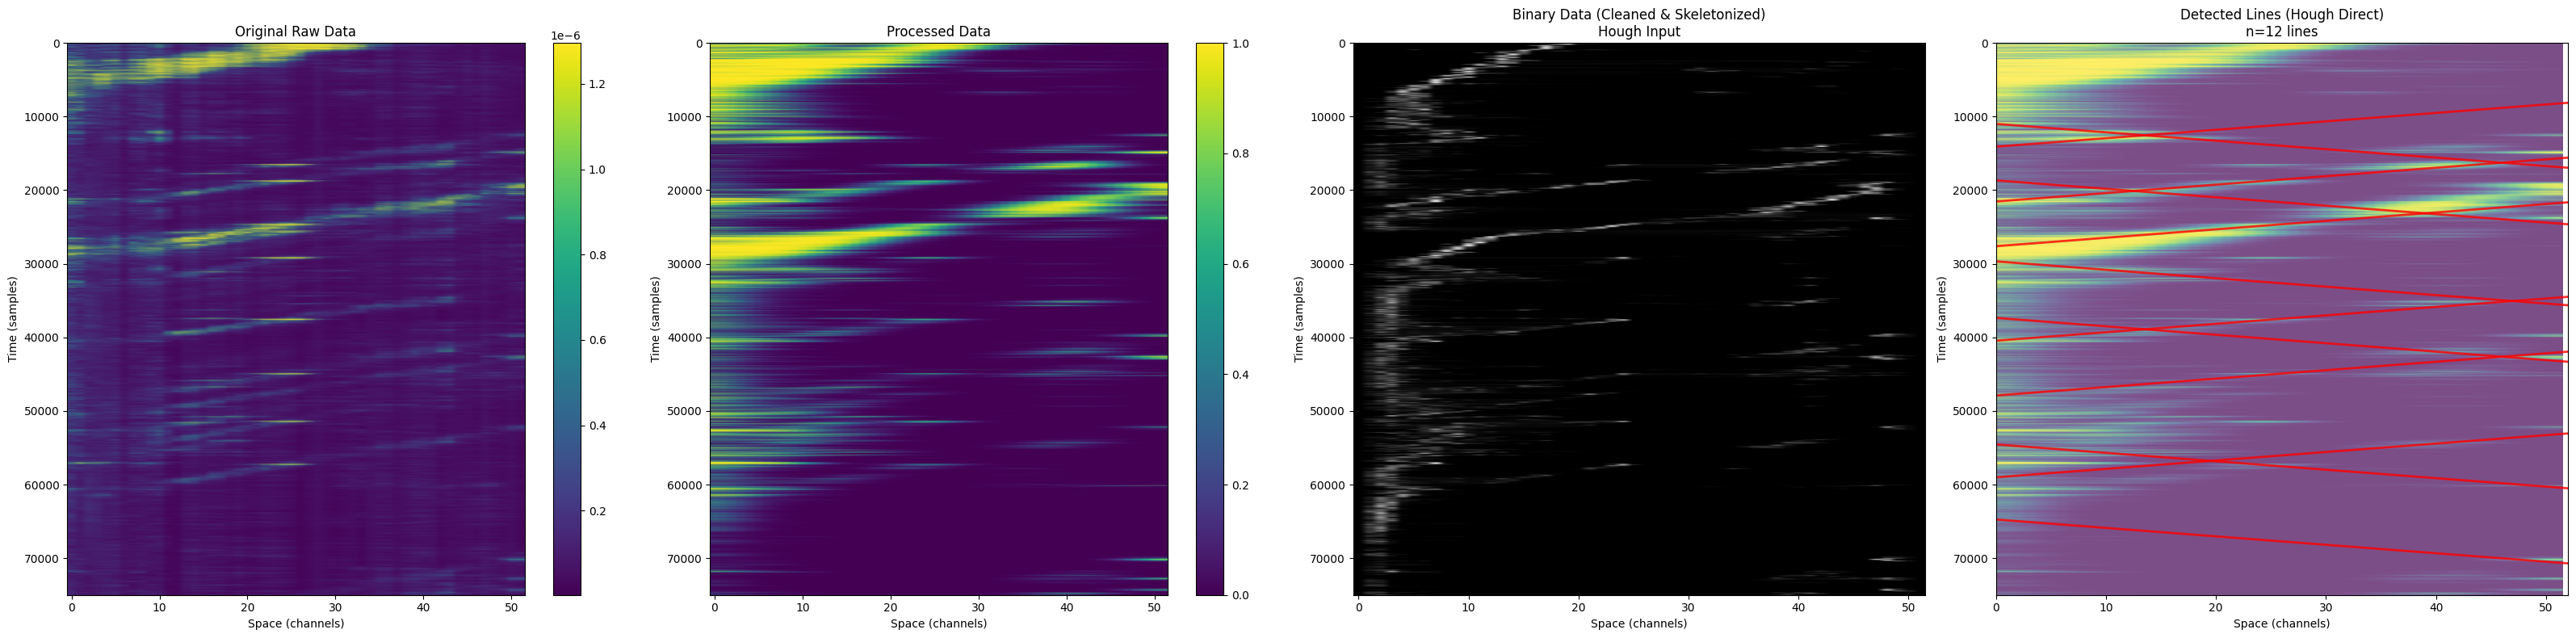


HOUGH DIRECT DETECTION RESULTS

Detected 12 objects:
Velocities (m/s): ['27.85', '27.85', '-27.85', '27.85', '27.85', '-27.85', '-27.85', '27.85', '-27.85', '27.85', '-27.85', '-27.85']
Velocities (km/h): ['100.27', '100.27', '-100.27', '100.27', '100.27', '-100.27', '-100.27', '100.27', '-100.27', '100.27', '-100.27', '-100.27']

Mean velocity: 0.00 m/s (0.00 km/h)
Velocity range: -27.85 - 27.85 m/s
Std deviation: 27.85 m/s


(<Figure size 3200x800 with 6 Axes>,
 array([<Axes: title={'center': 'Original Raw Data'}, xlabel='Space (channels)', ylabel='Time (samples)'>,
        <Axes: title={'center': 'Processed Data'}, xlabel='Space (channels)', ylabel='Time (samples)'>,
        <Axes: title={'center': 'Binary Data (Cleaned & Skeletonized)\nHough Input'}, xlabel='Space (channels)', ylabel='Time (samples)'>,
        <Axes: title={'center': 'Detected Lines (Hough Direct)\nn=12 lines'}, xlabel='Space (channels)', ylabel='Time (samples)'>],
       dtype=object))

In [222]:
# Test direct Hough Transform with skeletonization (cleans up binary data)
raw_data = get_range(range3[0], range3[1])
preprocessing_result = remove_spatial_noise(raw_data, method='median', window_size=5)
filtered_data = bandpass_filter(preprocessing_result, lowcut=5, highcut=50, order=4)

# Apply enhancements
enh_grad = enhance_gradient(filtered_data, sigma=1)
enh_morph = enhance_morphological(enh_grad, size=(5, 5), suppress_background=True, threshold_percentile=70)

# Direct Hough detection with skeletonization and morphological cleaning
detection_hough = detect_lines_hough_direct(
    enh_morph,
    apply_transform=False,
    denoise_sigma=2.5,
    threshold_percentile=85,
    hough_threshold=80,
    min_distance=50,
    min_angle=10,
    velocity_range=(0.5, 30),
    use_skeletonize=True,      # Thin lines to 1-pixel width
    morphology_clean=True       # Remove small noise objects
)


# Visualize results
plot_hough_direct_results(detection_hough, raw_data)

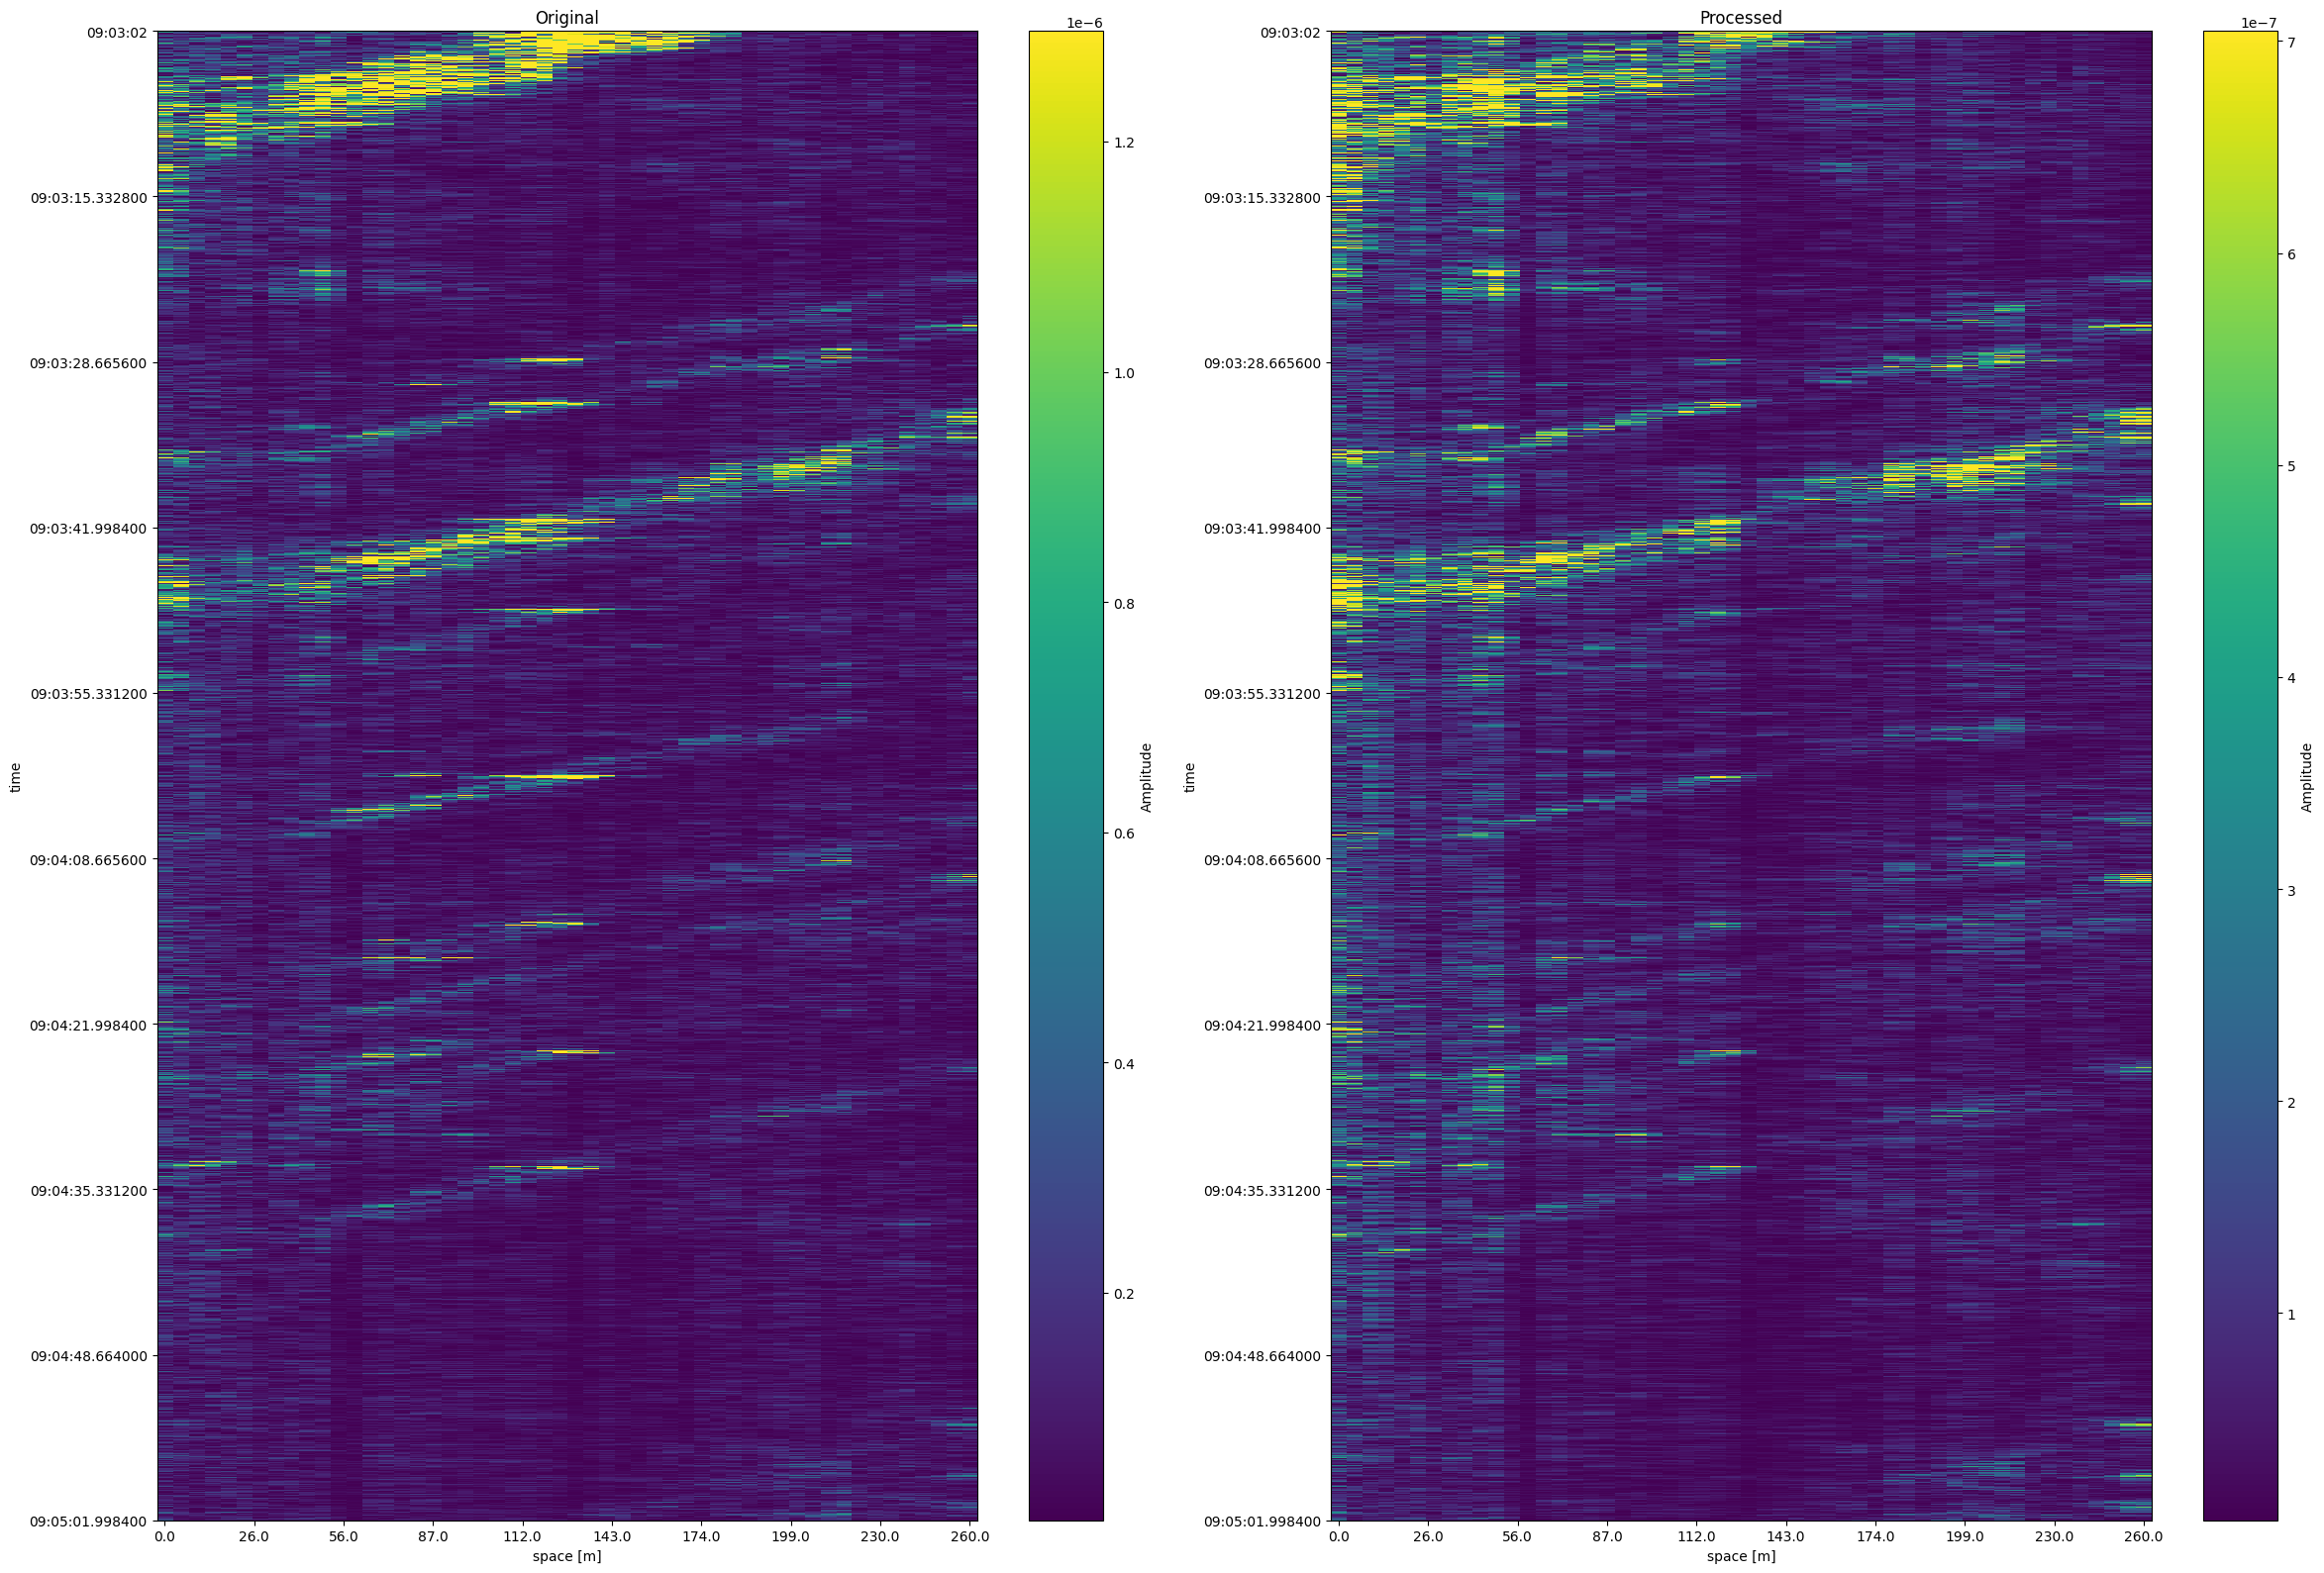

KeyboardInterrupt: 

In [206]:
raw_data = get_range(range1[0], range1[1])
filtered_data = bandpass_filter(raw_data, lowcut=5, highcut=50)
#filtered_data['df'] = filtered_data['df'] ** 2

plot_comparison(raw_data, filtered_data)

detection_result = detect_objects(filtered_data, canny_sigma=0.5)
plot_detection_results(detection_result, raw_data)


In [ ]:
# Test different background suppression methods
raw_data = get_range(range1[0], range1[1])
preprocessing_result = remove_spatial_noise(raw_data, method='median', window_size=5)
filtered_data = bandpass_filter(preprocessing_result, lowcut=5, highcut=50, order=4)

# Apply gradient enhancement
enh_grad = enhance_gradient(filtered_data, sigma=1)

# Apply morphological enhancement with built-in background suppression
enh_morph_suppressed = enhance_morphological(enh_grad, size=(5, 5), suppress_background=True, threshold_percentile=65)

# Or use the dedicated background suppression function
enh_morph_basic = enhance_morphological(enh_grad, size=(5, 5), suppress_background=False)
enh_final = suppress_background(enh_morph_basic, method='threshold', threshold_percentile=70)

# Compare results
plot_comparison(enh_grad, enh_morph_suppressed, 
                title1="After Gradient", 
                title2="Morphological + Background Suppression",
                apply_transform=False)

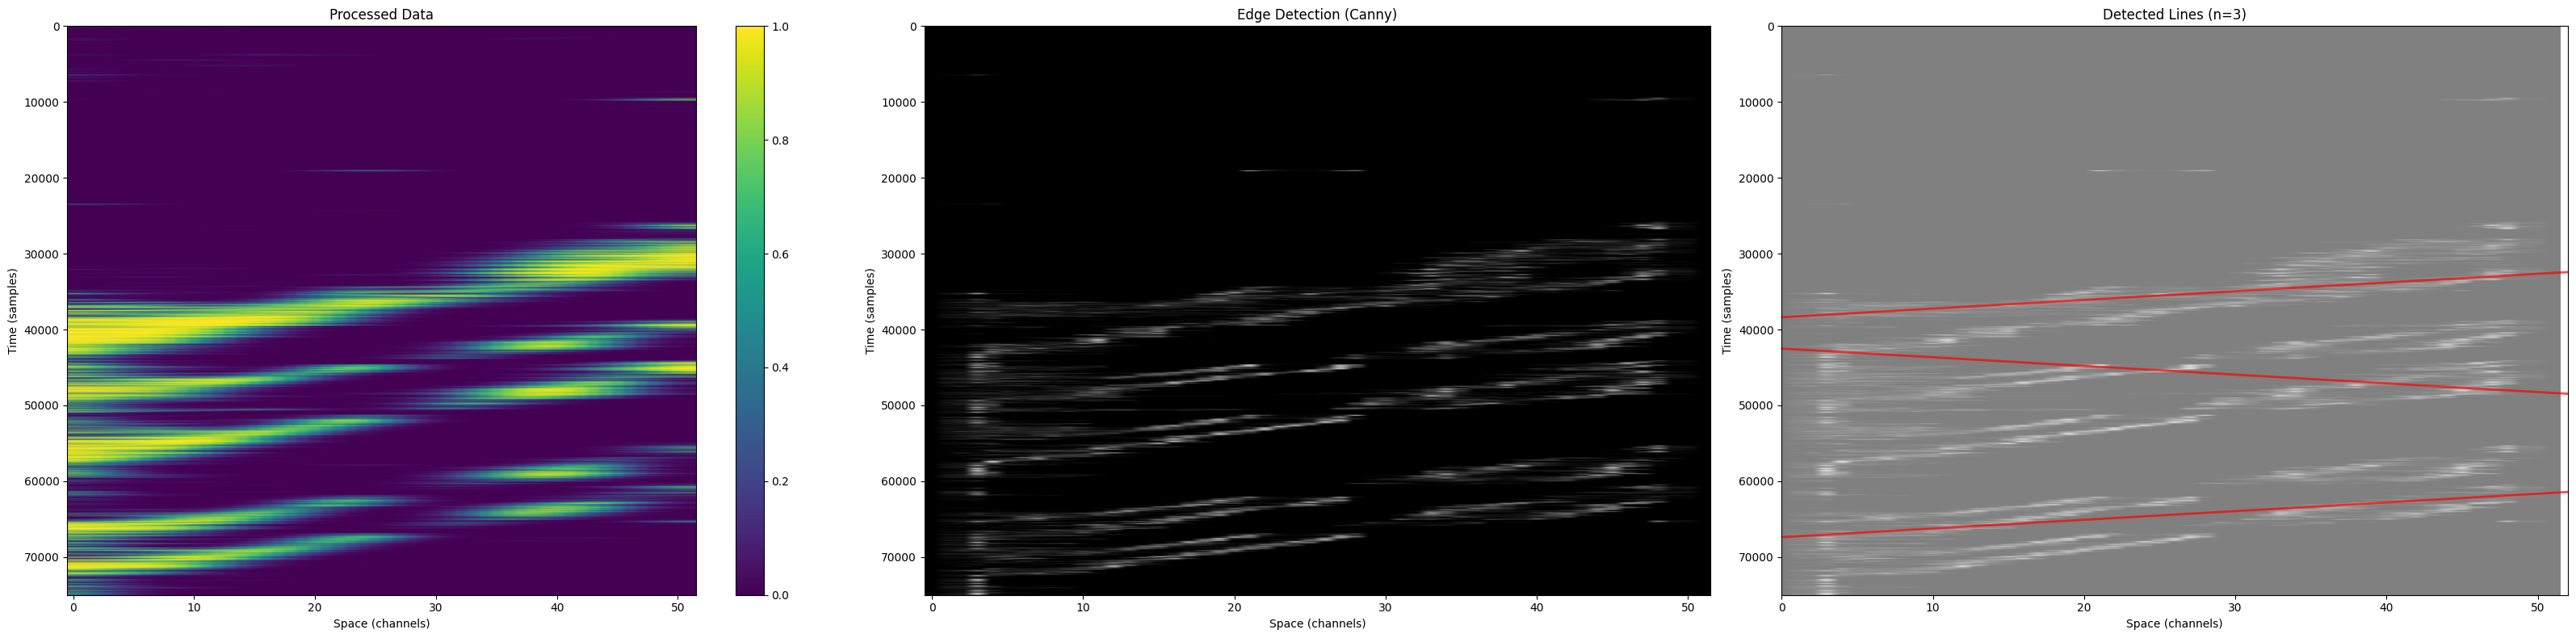


Detected 3 objects:
Velocities (m/s): ['27.85', '27.85', '-27.85']
Velocities (km/h): ['100.27', '100.27', '-100.27']

Mean velocity: 9.28 m/s (33.42 km/h)
Velocity range: -27.85 - 27.85 m/s


(<Figure size 3200x800 with 4 Axes>,
 array([<Axes: title={'center': 'Processed Data'}, xlabel='Space (channels)', ylabel='Time (samples)'>,
        <Axes: title={'center': 'Edge Detection (Canny)'}, xlabel='Space (channels)', ylabel='Time (samples)'>,
        <Axes: title={'center': 'Detected Lines (n=3)'}, xlabel='Space (channels)', ylabel='Time (samples)'>],
       dtype=object))

In [143]:
# Improved detection for enhanced data
raw_data = get_range(range1[0], range1[1])
preprocessing_result = remove_spatial_noise(raw_data, method='median', window_size=5)
filtered_data = bandpass_filter(preprocessing_result, lowcut=5, highcut=50, order=4)

# Apply enhancements
enh_grad = enhance_gradient(filtered_data, sigma=1)
enh_morph = enhance_morphological(enh_grad, size=(5, 5), suppress_background=True, threshold_percentile=70)

# Detection with improved parameters for enhanced data
detection_result = detect_objects(
    enh_morph, 
    apply_transform=False,  # Data is already processed
    denoise_pre_canny=True,  # Smooth before edge detection
    denoise_sigma=2.5,  # Higher smoothing to reduce noise
    threshold_before_canny=True,  # Remove weak signals
    threshold_percentile=85,  # Keep only strong signals
    canny_sigma=1.5,  # Higher sigma for Canny
    canny_low=0.3,  # Higher thresholds to reduce false edges
    canny_high=0.6,
    hough_threshold=80,  # Higher threshold for line detection
    hough_line_length=100  # Require longer lines
)

plot_detection_results(detection_result)

Testing different detection methods...

[1/3] Canny + Hough Transform...
[2/3] Template Correlation...
[2/3] Template Correlation...
[3/3] Ridge Detection...
[3/3] Ridge Detection...

✓ All methods complete!

✓ All methods complete!


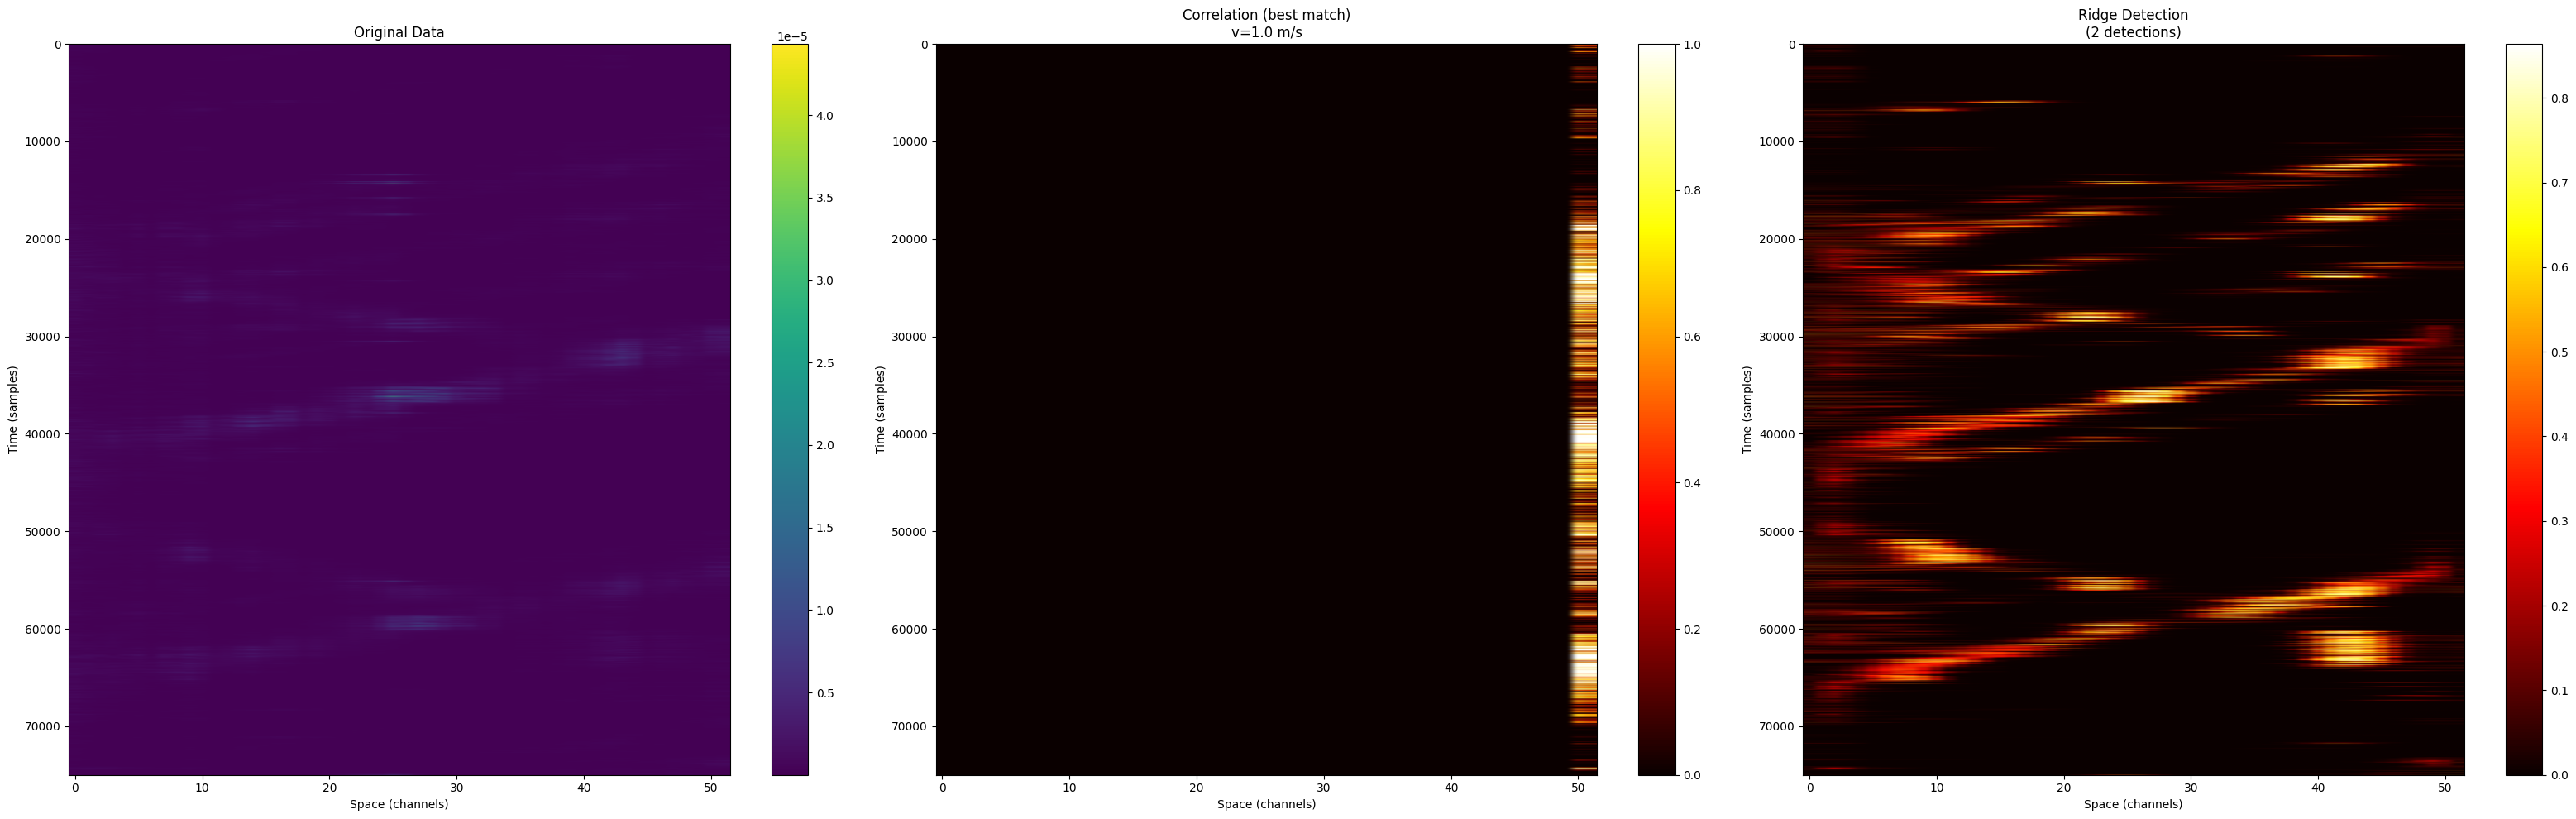


DETECTION RESULTS COMPARISON

Template Correlation: 20 velocity candidates
  Detected velocities: ['1.0', '2.3', '3.5', '4.8', '6.1', '7.3', '8.6', '9.8', '11.1', '12.4', '13.6', '14.9', '16.2', '17.4', '18.7', '19.9', '21.2', '22.5', '23.7', '25.0'] m/s

Ridge Detection: 2 detections
  Mean velocity: 0.00 m/s (0.00 km/h)
  Velocity range: -5.08 - 5.08 m/s



In [200]:
# Compare different detection methods
raw_data = get_range(range2[0], range2[1])
preprocessing_result = remove_spatial_noise(raw_data, method='median', window_size=5)
filtered_data = bandpass_filter(preprocessing_result, lowcut=5, highcut=50, order=4)

# Apply enhancements
enh_grad = enhance_gradient(filtered_data, sigma=1)
enh_morph = enhance_morphological(enh_grad, size=(5, 5), suppress_background=True, threshold_percentile=70)

print("Testing different detection methods...\n")

# Method 1: Canny + Hough (original)
print("[1/3] Canny + Hough Transform...")
detection_canny = detect_objects(
    enh_morph, 
    apply_transform=False,
    denoise_pre_canny=True,
    denoise_sigma=2.5,
    threshold_before_canny=True,
    threshold_percentile=85,
    canny_sigma=1.5,
    canny_low=0.3,
    canny_high=0.6,
    hough_threshold=80,
    hough_line_length=100
)

# Method 2: Template Correlation
print("[2/3] Template Correlation...")
detection_correlation = detect_objects_correlation(
    enh_morph,
    apply_transform=False,
    denoise_sigma=2.5,
    threshold_percentile=85,
    min_line_length=100,
    velocity_range=(1, 25)
)

# Method 3: Ridge Detection
print("[3/3] Ridge Detection...")
detection_ridge = detect_objects_ridge(
    enh_morph,
    apply_transform=False,
    denoise_sigma=2.5,
    threshold_percentile=85,
    ridge_sigma=3.0,
    min_ridge_length=50
)

print("\n✓ All methods complete!")

# Visualize comparison
plot_alternative_detections(
    correlation_result=detection_correlation,
    ridge_result=detection_ridge,
    original_data=raw_data
)

In [216]:
# Test ridge detection with new visualization
raw_data = get_range(range2[0], range2[1])
preprocessing_result = remove_spatial_noise(raw_data, method='median', window_size=5)
filtered_data = bandpass_filter(preprocessing_result, lowcut=5, highcut=50, order=4)

# Apply enhancements
enh_grad = enhance_gradient(filtered_data, sigma=1)
enh_morph = enhance_morphological(enh_grad, size=(5, 5), suppress_background=True, threshold_percentile=70)

# Ridge detection
detection_ridge = detect_objects_ridge(
    enh_morph,
    apply_transform=False,
    denoise_sigma=2.5,
    threshold_percentile=85,
    ridge_sigma=3.0,
    min_ridge_length=50
)

# Use the new dedicated ridge visualization
plot_ridge_detection_results(detection_ridge, raw_data)

KeyboardInterrupt: 